In [9]:
# Описание поставленной задачи

# Требуется удалить фон у центрального объекта изображения, то есть необходимо осуществить задачу сегментации изображения, где каждый пиксель будет 
# классифицирован в рамках "фон" или "объект", с дальнейший наложением белой маски на изображение там, где отсутствует объект.

# Следовательной, необходимо в первую очередь решить проблему сегмантации и подобрать соотвутствующие данные для дальнейшего обучения нейронной сети.

In [10]:
# Описание Датасетов

# 1. Cityscapes Image Pairs
# Данные о городских пейзажах (домашняя страница набора данных) содержат помеченные видео, 
# снятые с транспортных средств, управляемых в Германии. 
# Эта версия представляет собой обработанную подвыборку, созданную как часть документа Pix2Pix. 
# Набор данных содержит неподвижные изображения из исходных видеороликов, 
# а метки семантической сегментации отображаются на изображениях рядом с исходным изображением. 
# Это один из лучших наборов данных для задач семантической сегментации.
# Этот набор данных содержит 2975 файлов обучающих изображений и 500 файлов проверочных изображений. 
# Каждый файл изображения имеет размер 256x512 пикселей,
# и каждый файл представляет собой композит с исходной фотографией в левой половине изображения, 
# рядом с помеченным изображением (результат семантической сегментации) в правой половине.

# https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs

# 2.The COCO-Stuff dataset
# COCO-Stuff дополняет все 164K изображений популярного набора данных COCO [2] аннотациями на уровне пикселей. 
# Эти аннотации можно использовать для задач понимания сцены, таких как семантическая сегментация, обнаружение объектов и субтитры к изображениям.
# Все лучшие собранные датасеты COCO-Stuff со статистикой.
# https://github.com/nightrome/cocostuff

# 3. ADE20K
# Набор данных ADE20K содержит более 20 тысяч изображений, ориентированных на сцены, с исчерпывающими комментариями к объектам и частям объектов. 
# В частности, бенчмарк разделен на 20 тыс. изображений для обучения, 2 тыс. изображений для проверки и еще одну партию готовых изображений для тестирования. 
# Всего для оценки включено 150 семантических категорий, которые включают такие предметы, как небо, дорога, трава, а также 
# отдельные объекты, такие как человек, автомобиль, кровать. Обратите внимание, что на изображениях наблюдается неравномерное распределение объектов, 
# имитирующее более естественное появление объектов в повседневной сцене.

# http://sceneparsing.csail.mit.edu/

# 4. PASCAL Visual Object Classes Challenge 2012
# 20 классов. Данные train/val содержат 11 530 изображений, содержащих 27 450 объектов с аннотацией ROI и 6 929 сегментов.
# http://host.robots.ox.ac.uk:8080/pascal/VOC/


In [11]:
# Описание всех текущих реализаций

# 1.Image-Segmentation-with-UNet
# Решение задачи сегментации изображения уличной среды на примере нейросети UNet с помощью датасета Cityscapes
# https://www.kaggle.com/code/gokulkarthik/image-segmentation-with-unet-pytorch/notebook

# 2.Introduction to Semantic Segmentation with fcn resnet_101
# Решение задачи сегментации изображения на примере сравнения двух нейросетей - FCN и DeepLabv3 
# https://colab.research.google.com/github/spmallick/learnopencv/blob/master/PyTorch-Segmentation-torchvision/intro-seg.ipynb#scrollTo=KMdbwOEbeQ0s

# 3.Instance segmentation with maskrcnn_resnet50_fpn
# Испоьзование готовой предобученной модели для решения задачи сегментации
# https://colab.research.google.com/drive/1b3TwHdeWAgmZ7n1eOFbzVw1T0oZvC9U6?usp=sharing#scrollTo=sPwMdED4tJ9M

# 4. Semantic Segmentation
# Содержит:
# (Deeplab V3+) Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation
# (GCN) Large Kernel Matter, Improve Semantic Segmentation by Global Convolutional Network
# (UperNet) Unified Perceptual Parsing for Scene Understanding
# (DUC, HDC) Understanding Convolution for Semantic Segmentation
# (PSPNet) Pyramid Scene Parsing Network
# (ENet) A Deep Neural Network Architecture for Real-Time Semantic Segmentatio
# (U-Net) Convolutional Networks for Biomedical Image Segmentation (2015)
# (SegNet) A Deep ConvolutionalEncoder-Decoder Architecture for ImageSegmentation (2016)
# (FCN) Fully Convolutional Networks for Semantic Segmentation (2015)
# https://github.com/yassouali/pytorch-segmentation#models

In [12]:
# Подход к обработки данных

In [13]:
!pip install pyTelegramBotAPI
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as pli
import torch
import numpy as np
import cv2
import torchvision.transforms as T
from io import BytesIO
from skimage import io


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import telebot
token = '5331173165:AAHt7PEr72frv6QNslq5gc1jdEYCmL_59is'
bot = telebot.TeleBot(token)

In [15]:
@bot.message_handler(content_types=['text'])

def get_text_messages(message):
  if message.text == "Привет":
    send = bot.send_message(message.from_user.id, "Привет, я занимаюсь удалением фона с картинки, но только у определенных обьектов. Весь список объектов можно получить в /help. Все что нужно это просто отправить мне фотографию в формате jpeg.")
    bot.register_next_step_handler(send, handle_docs_document)
  elif message.text == "/help":
    bot.send_message(message.from_user.id, "1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle, 6=bus, 7=car, 8=cat, 9=chair, 10=cow, 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person, 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor.")
  else:
    bot.send_message(message.from_user.id, "Я тебя не понимаю. ")

def handle_docs_document(message):
    if message.content_type == 'photo':
      # print ('message.photo =', message.photo)
      # fileID = message.photo[-1].file_id
      # print ('fileID =', fileID)
      # file = bot.get_file(fileID)
      # print ('file.file_path =', file.file_path)
      # bot.send_message(message.from_user.id, "Картинку получил ")
      # img = file.file_path
      # new_photo = Delete_Background(img)
      # bot.send_photo(message.from_user.id, photo=open(new_photo, 'rb'))
      fileID = message.photo[-1].file_id
      # print ('fileID =', fileID)
      file_info = bot.get_file(fileID)
      # print ('file.file_path =', file_info.file_path)
      downloaded_file = bot.download_file(file_info.file_path)
      print(downloaded_file)
      bot.send_message(message.from_user.id, "Картинку получил, обрабатываю... ")
      new_photo = Delete_Background(downloaded_file)

      pli.imsave('name.png', new_photo)

      bot.send_photo(message.from_user.id, photo=open('name.png', 'rb'))

def Delete_Background(img):
    # Define the helper function
  def decode_segmap(image1, nc=21):
    # Load the foreground input image
    photo=BytesIO(img)
    foreground = io.imread(photo)
    size=np.array(image1.shape)
    print(size)
    foreground = cv2.resize(foreground, (size[1], 450))
    print(image1.shape)
    # Change the color of foreground image to RGB
    label_colors = np.array([(0, 0, 0),  # 0=background
                              # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                              (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
                              # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                              (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
                              # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
                              (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
                              # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
                              (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image1).astype(np.uint8)
    g = np.zeros_like(image1).astype(np.uint8)
    b = np.zeros_like(image1).astype(np.uint8)
      
    for l in range(0, nc):
          idx = image1 == l
          r[idx] = label_colors[l, 0]
          g[idx] = label_colors[l, 1]
          b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    print(rgb.shape)
    # and resize image to match shape of R-band in RGB output map
    #foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
    # Convert uint8 to float
    pic = foreground.astype(np.uint8)
    # Create a binary mask of the RGB output map using the threshold value 0
    th, alpha = cv2.threshold(np.array(rgb), 0, 255, cv2.THRESH_BINARY)

    plt.imshow(alpha)
    plt.axis('off')
    plt.show()

    resized = cv2.resize(foreground, (foreground.shape[1],foreground.shape[0]))
    print("Разделение")
    #cv2_imshow(alpha)
    # Apply a slight blur to the mask to soften edges
    alpha = cv2.GaussianBlur(alpha, (7, 7), 0)

    alpha =cv2.cvtColor(alpha, cv2.COLOR_BGR2GRAY)


    #alpha_new=np.delete(alpha, 0, -1)
    #alpha_new=np.delete(alpha_new, 0, -2)
    #cv2_imshow(alpha)
    #alpha = alpha.astype(float) / 255

    alpha_new=alpha[:][:][-1]

    print(resized.shape)
    print(alpha.shape)
    print(alpha_new.shape)

    #print(type(alpha[0][0][0]))
    #print(type(resized[0][0][0]))

    out_img = cv2.bitwise_and(resized,resized,mask = alpha)

    plt.imshow(alpha)
    #plt.imshow(alpha_new)
    plt.imshow(out_img)
    plt.axis('off')
    plt.show()


    return out_img/255


  def segment(net, img1, show_orig=True, dev='cuda'):
      #img = Image.open(path)
      if show_orig:
          plt.imshow(img1)
          plt.axis('off')
          plt.show()
      # Comment the Resize and CenterCrop for better inference results
      trf = T.Compose([T.Resize(450),
                      #T.CenterCrop(450),
                      T.ToTensor(),
                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])])
      
      dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      inp = trf(img1).unsqueeze(0).to(dev)
      out = net.to(dev)(inp)['out']
      om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()

      rgb = decode_segmap(om)

      # plt.imshow(rgb)
      # plt.axis('off')
      # plt.show()
      # bot.send_photo(message.from_user.id, photo=open(rgb, 'rb'))
      return rgb
  dlab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()
  image=Image.open(BytesIO(img))
  rgb = segment(dlab, image, show_orig=True)
  return rgb

# Новый раздел

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x04\x03\x03\x04\x03\x03\x04\x04\x03\x04\x05\x04\x04\x05\x06\n\x07\x06\x06\x06\x06\r\t\n\x08\n\x0f\r\x10\x10\x0f\r\x0f\x0e\x11\x13\x18\x14\x11\x12\x17\x12\x0e\x0f\x15\x1c\x15\x17\x19\x19\x1b\x1b\x1b\x10\x14\x1d\x1f\x1d\x1a\x1f\x18\x1a\x1b\x1a\xff\xdb\x00C\x01\x04\x05\x05\x06\x05\x06\x0c\x07\x07\x0c\x1a\x11\x0f\x11\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\xff\xc2\x00\x11\x08\x06\xab\n\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x00\x03\x04\x05\x06\x07\x08\xff\xc4\x00\x1a\x01\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x01\xf3\x90\xcf\xa9\xe1\x06K!\x90\x92\x12HI$\xa3

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


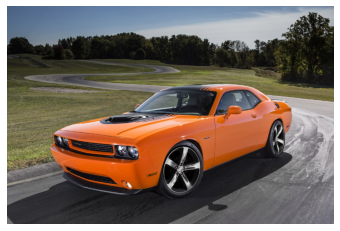

[450 674]
(450, 674)
(450, 674, 3)


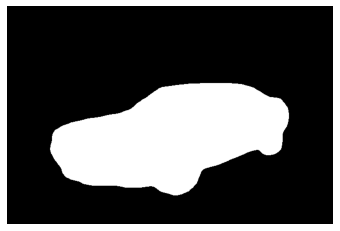

Разделение
(450, 674, 3)
(450, 674)
(674,)


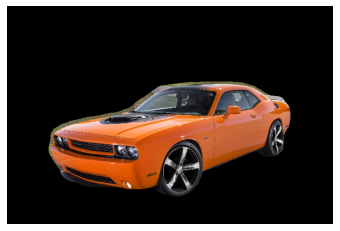

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x04\x03\x03\x04\x03\x03\x04\x04\x03\x04\x05\x04\x04\x05\x06\n\x07\x06\x06\x06\x06\r\t\n\x08\n\x0f\r\x10\x10\x0f\r\x0f\x0e\x11\x13\x18\x14\x11\x12\x17\x12\x0e\x0f\x15\x1c\x15\x17\x19\x19\x1b\x1b\x1b\x10\x14\x1d\x1f\x1d\x1a\x1f\x18\x1a\x1b\x1a\xff\xdb\x00C\x01\x04\x05\x05\x06\x05\x06\x0c\x07\x07\x0c\x1a\x11\x0f\x11\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\xff\xc2\x00\x11\x08\x01\xf4\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x00\x01\x02\x05\x06\x07\x08\xff\xc4\x00\x19\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x01\xf3\x80 <\xde\x95\xe6u\xd3\x19\xbb\x86e\xd93\x

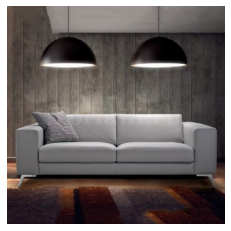

[450 450]
(450, 450)
(450, 450, 3)


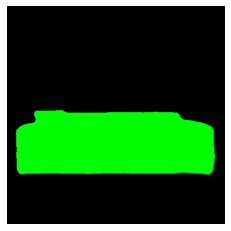

Разделение
(450, 450, 3)
(450, 450)
(450,)


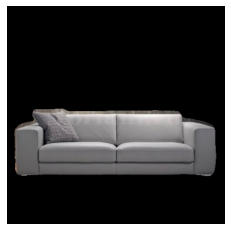

In [ ]:
bot.polling(none_stop=True, interval=0)